## scikit-learn sample_weight compliance investigative plots

This notebook runs compliance tests on a given scikit-learn estimators. This allows one to plot different features of the resulting predictions and scores with and without weights, so as to check weighted-repeated equivalence.

In [1]:
import sklearn
import threadpoolctl
import os
os.environ["SCIPY_ARRAY_API"] = "1"

# HistGradientBoostingClassifier trashes the OpenMP thread pool on repeated
# small fits.
_ = threadpoolctl.threadpool_limits(limits=1, user_api="openmp")

sklearn.show_versions()


System:
    python: 3.13.11 | packaged by conda-forge | (main, Dec  6 2025, 11:28:54) [Clang 19.1.7 ]
executable: /Users/ogrisel/miniforge3/envs/dev/bin/python
   machine: macOS-15.6.1-arm64-arm-64bit-Mach-O

Python dependencies:
      sklearn: 1.9.dev0
          pip: 25.3
   setuptools: 80.9.0
        numpy: 2.4.0
        scipy: 1.16.3
       Cython: 3.2.4
       pandas: 3.0.0.dev0+2566.g2bb3fef887
   matplotlib: 3.10.8
       joblib: 1.3.0
threadpoolctl: 3.6.0

Built with OpenMP: True

threadpoolctl info:
       user_api: blas
   internal_api: openblas
    num_threads: 10
         prefix: libopenblas
       filepath: /Users/ogrisel/miniforge3/envs/dev/lib/libopenblas.0.dylib
        version: 0.3.30
threading_layer: openmp
   architecture: VORTEX

       user_api: openmp
   internal_api: openmp
    num_threads: 1
         prefix: libomp
       filepath: /Users/ogrisel/miniforge3/envs/dev/lib/libomp.dylib
        version: None


In [2]:
import warnings

warnings.simplefilter("error", category=UserWarning)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sample_weight_audit import check_weighted_repeated_estimator_fit_equivalence
from sklearn.cluster import MiniBatchKMeans



estimator = MiniBatchKMeans(n_clusters=10, batch_size=10, random_state=0)
estimator_name = estimator.__class__.__name__

result = check_weighted_repeated_estimator_fit_equivalence(
    estimator,
    estimator_name,
    test_name="kstest",
    n_stochastic_fits=1_000,
    n_samples_per_cv_group=500,
    store_estimators=True,
    random_state=0,
)

100%|██████████| 1000/1000 [00:03<00:00, 280.05it/s]


In [4]:
# result.to_dict()['estimators_weighted']

# Make plots of scores

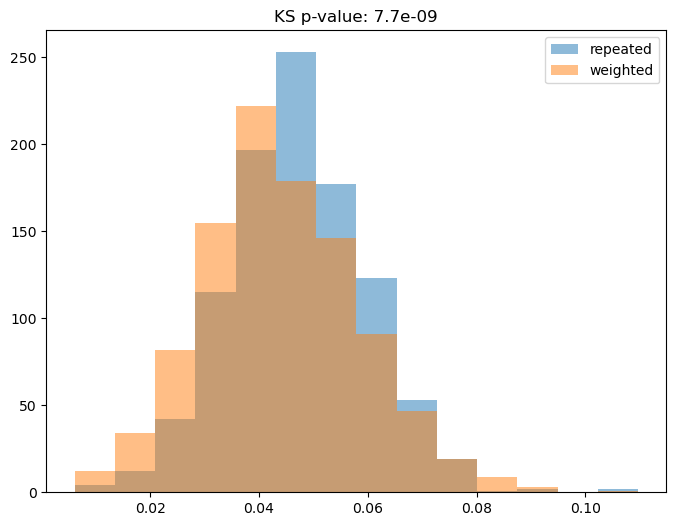

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

alpha = 0.5
eps = 1e-6
min_score = min(result.scores_repeated.min(), result.scores_weighted.min())
max_score = max(result.scores_repeated.max(), result.scores_weighted.max())
if max_score - min_score < eps:
    min_score -= eps
    max_score += eps

bins_scores = np.linspace(min_score, max_score, 15)
ax.hist(result.scores_repeated, alpha=alpha, bins=bins_scores, label="repeated")
ax.hist(result.scores_weighted, alpha=alpha, bins=bins_scores, label="weighted")
ax.legend()
_ = ax.set_title(f"KS p-value: {result.pvalue:.2g}")

# Make plots of predictions

## Plot the histograms of predictions for some randomly selected test points

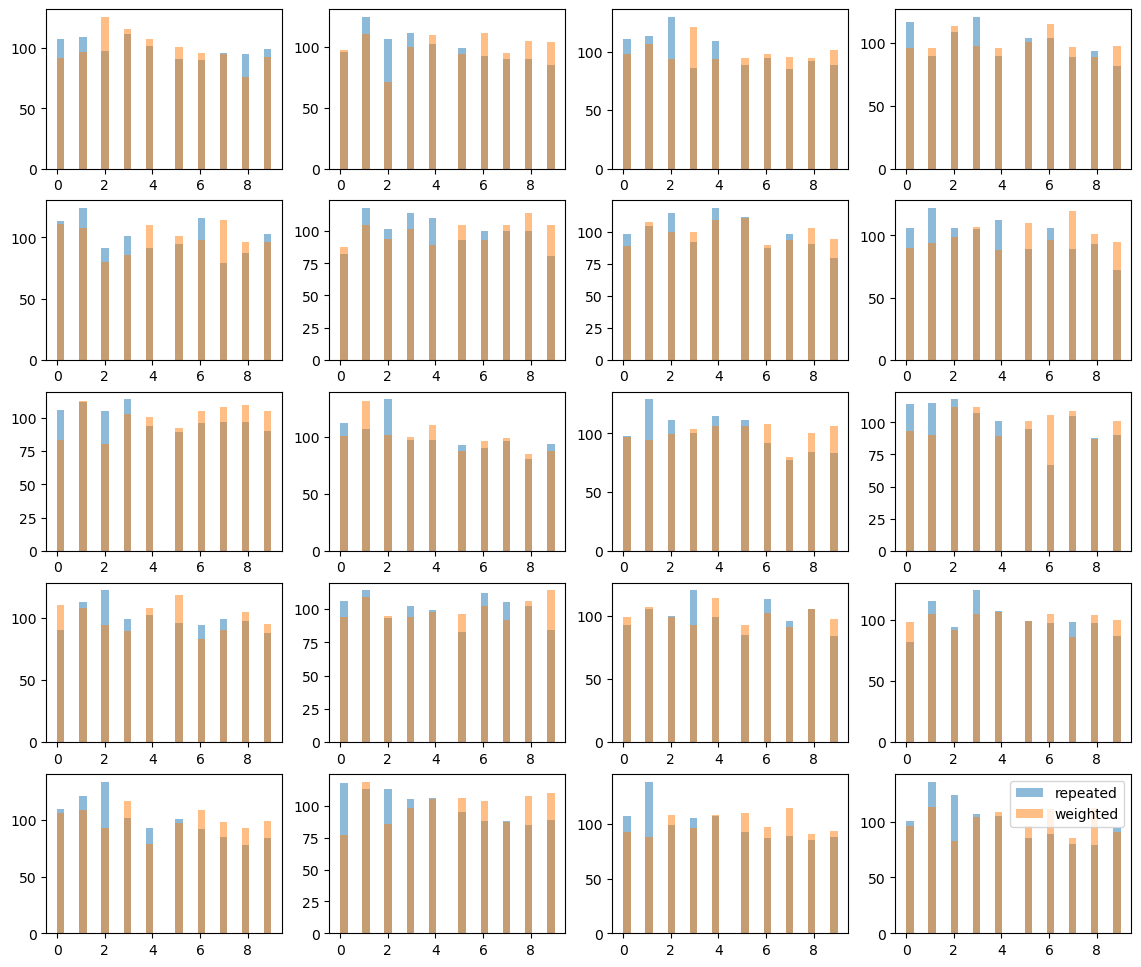

In [6]:
fig, axs = plt.subplots(5, 4, figsize=(14, 12))
n_plots = len(axs.flatten())

rng = np.random.default_rng(0)
sample_indices = rng.choice(
    np.arange(result.predictions_weighted.shape[1]), size=n_plots, replace=False
)

min_prediction = min(
    result.predictions_repeated.min(), result.predictions_weighted.min()
)
max_prediction = max(
    result.predictions_repeated.max(), result.predictions_weighted.max()
)
if max_prediction - min_prediction < eps:
    min_prediction -= eps
    max_prediction += eps
bins_predictions = np.linspace(min_prediction, max_prediction, 30)

for sample_idx, ax in zip(sample_indices, axs.flatten()):
    ax.hist(
        result.predictions_repeated[:, sample_idx].flatten(),
        alpha=alpha,
        bins=bins_predictions,
        label="repeated",
    )
    ax.hist(
        result.predictions_weighted[:, sample_idx].flatten(),
        alpha=alpha,
        bins=bins_predictions,
        label="weighted",
    )

# Show the legend only on the last subplot
_ = ax.legend()


## Zooming into individual samples

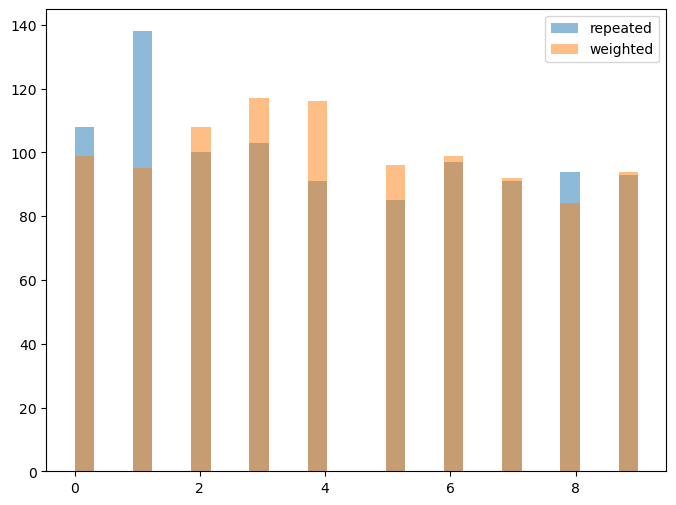

In [7]:
fig,ax = plt.subplots(1,1,figsize=(8, 6))

sample_idx = 50
ax.hist(result.predictions_repeated[:, sample_idx].flatten(), alpha=alpha, bins=bins_predictions, label='repeated')
ax.hist(result.predictions_weighted[:, sample_idx].flatten(), alpha=alpha, bins=bins_predictions, label='weighted')
_ = ax.legend()